# 来自肺部 CT 扫描的 3D 图像分类
作者: [KHB1698](https://github.com/KHB1698)

日期: 2021.09

摘要: 本示例教程演示如何对肺部 CT 扫描的 3D 图像分类


## 1. 简要介绍
该示例将显示构建3D卷积神经网络（CNN）所需的步骤，以预测计算机断层扫描（CT）扫描中病毒性肺炎的存在。 2D CNN通常用于处理RGB图像（3个通道）。 3D CNN仅仅是3D等效项：它需要输入3D 图形或2D帧序列（例如，CT扫描中的切片），3D CNN是用于体积数据的学习表示的强大模型。


## 2. 环境设置
本教程基于Paddle 2.1 编写，如果您的环境不是本版本，请先参考[官网](https://www.paddlepaddle.org.cn/install/quick?docurl=/documentation/docs/zh/install/pip/windows-pip.html)安装 Paddle 2.1 。

In [ ]:
import os
import zipfile
import numpy as np
import paddle
from paddle.nn import functional as F
paddle.__version__

'2.1.2'

## 3. 数据集
在此示例中，我们使用MOSMEDDATA的子集：[ MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1)（COVID-19相关发现的胸部CT扫描）。该数据集由Covid-19相关发现的肺部CT扫描，以及没有相关发现的肺部CT组成。

我们将使用CT扫描的相关放射发现作为标签来构建分类器以预测病毒性肺炎的存在。因此，任务是二分类问题。


> 本项目数据集可以直接用wget命令下载，但由于下载时间太长，我将数据上传到了项目数据集中


```python
# wget下载命令如下
!wget https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip
!wget https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip
```


In [ ]:
# 制作一个目录来存储数据。
os.makedirs("MosMedData")
# 在新创建的目录中解压缩数据。
with zipfile.ZipFile("data/data106304/CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("data/data106304/CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

### 3.1 加载数据和预处理

这些文件以NIFTI格式提供，扩展名为.nii。要阅读扫描，我们使用`nibabel`包。您可以通过`pip install nibabel`安装包。 CT扫描以Hounsfield单位（HU）存储原始体素强度。在这个数据集中，它们的范围从-1024到2000以上。400以上的骨骼具有不同的放射性强度，因此这被用作更高的界限。通常使用-1000到400之间的阈值来规范CT扫描。

要处理数据，我们执行以下操作：

- 我们首先将体积旋转90度，因此方向是固定的。
- 我们将HU值缩放为介于0和1之间。
- 我们调整宽度，高度和深度的大小。

在这里，我们定义了几个辅助函数来处理数据。在构建训练和验证数据集时将使用这些功能。


In [ ]:
# nii.gz格式是医学图像常用的压缩格式，python中可用nibabel来读取保存。
!pip install nibabel

In [ ]:

import nibabel as nib

from scipy import ndimage

def read_nifti_file(filepath):
    """读取和加载数据"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """数据归一化"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """跨 z 轴调整大小"""
    # 设置所需的深度
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # 获取当前深度
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # 计算深度因子
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # 旋转
    img = ndimage.rotate(img, 90, reshape=False)
    # 跨z轴调整大侠
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """读取和调整数据大小"""
    # 读取扫描文件
    volume = read_nifti_file(path)
    # 归一化
    volume = normalize(volume)
    # 调整宽度、高度和深度
    volume = resize_volume(volume)
    return volume

让我们从类目录中读取CT扫描的路径。

In [ ]:
# 文件夹“CT-0”由具有正常肺组织的CT扫描组成，没有病毒性肺炎的CT征象。
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# 文件夹 "CT-23 "包括有几个磨玻璃不透明的CT扫描件，肺实质受累。
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


### 3.2 划分训练和验证数据集

从目录中读取扫描并分配标签。扫描图像以具有128x128x64的形状。将原始HU值重新归类为0到1的范围。最后将数据集分成训练和验证子集。

In [ ]:
# 阅读并处理扫描文件，每次扫描都会调整横跨高度，宽度和深度和深度并重新缩放。
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# 对于具有病毒性肺炎的CT扫描分配1，对于正常分配0。
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# 在比率70-30中分割数据以进行培训和验证。
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


### 3.3 数据集定义

使用飞桨框架高层API的 paddle.io.Dataset 自定义数据集类，具体可以参考官网文档 自定义数据集。

自定义的数据集要重写` __init__` ，并实现 `__getitem__ `和 `__len__`。

In [ ]:
# 按照Dataset的使用规范，构建肺部数据集

from paddle.io import Dataset

class CTDataset(Dataset):
    # 肺部扫描数据集
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, x, y, transform=None):
        """
        步骤二：实现构造函数，定义数据集大小
        Args:
            x: 图像
            y: 图片存储的文件夹路径
            transform (callable, optional): 应用于图像上的数据处理方法
        """
        self.x = x
        self.y = y
        self.transform = transform # 获取 transform 方法

    def __getitem__(self, idx):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据/测试数据，对应的标签）
        """
        img = self.x[idx]
        label = self.y[idx]
        # 如果定义了transform方法，使用transform方法
        if self.transform:
            img,label = self.transform([img,label])
        # 因为上面我们已经把数据集处理好了生成了numpy形式，没必要处理了
        return img, label

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return len(self.y) # 返回数据集大小，即图片的数量



### 3.4 数据可视化

实例化数据集并显示一些图像。

Dimension of the CT scan is: (128, 128, 64)
label is: 1


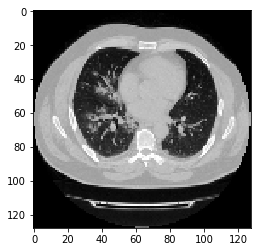

In [ ]:
import matplotlib.pyplot as plt
train_dataset = CTDataset(x_train,y_train)

images, labels = train_dataset[11]
image = images
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
print("label is:",labels)

由于CT扫描有许多切片，因此让我们来看看切片的集合。

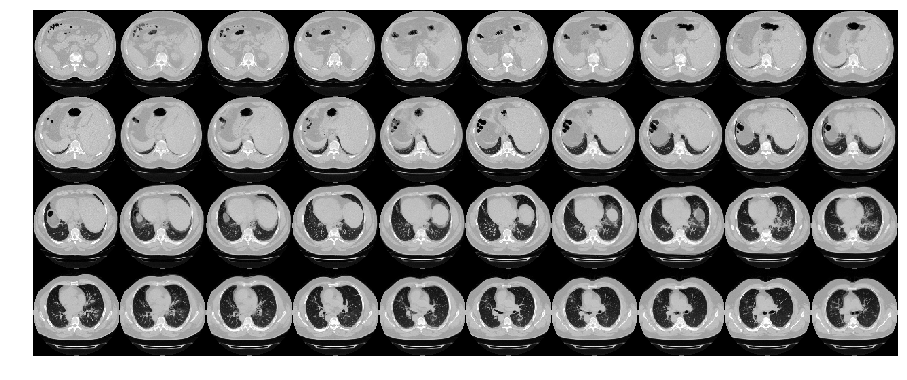

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

### 3.5 Transforms

CT扫描也通过在训练期间进行随机角度旋转来增强数据。由于数据存储在Rank-3的形状HWD（高度，宽度，深度）中，因此我们先把图像格式变为DHW，再在轴0处添加大小1的尺寸，以便能够对数据执行3D卷积。因此，新形状（1，深度，高度，宽度）。还有不同类型的预处理和增强技术，这个例子通过自定义transform进行了一些简单的操作。

```python
# 标准化自定义 transform 方法
# 飞桨现在的transform方法只能处理image数据暂时不能处理lable数据，所以我们要定义transform
class TransformAPI(object):
    """
    步骤一：继承 object 类
    """
    def __call__(self, data):

        """
        步骤二：在 __call__ 中定义数据处理方法
        """
        
        processed_data = data
        return  processed_data
```


In [ ]:
import paddle
import random
from scipy import ndimage
import paddle.vision.transforms.functional as F

# 将图像旋转几度
class Rotate(object):

    def __call__(self, data):
        
        image = data[0]
        key_pts = data[1]
        # 定义一些旋转角度
        angles = [-20, -10, -5, 5, 10, 20]
        # 随机挑选角度
        angle = random.choice(angles)
        # 旋转体积
        image = ndimage.rotate(image, angle, reshape=False)
        image[image < 0] = 0
        image[image > 1] = 1        
        return image, key_pts

# 将图像的格式由HWD改为CDHW
class ToCDHW(object):
    
    def __call__(self, data):
        
        image = data[0]
        key_pts = data[1]
        image = paddle.transpose(paddle.to_tensor(image),perm=[2,0,1])
        image = np.expand_dims(image,axis=0)
        return image, key_pts


### 3.6 数据定义

In [ ]:
from paddle.vision.transforms import Compose

# create the transformed dataset
train_dataset = CTDataset(x_train,y_train,transform=Compose([Rotate(),ToCDHW()]))
valid_dataset = CTDataset(x_train,y_train,transform=Compose([ToCDHW()]))


## 4. 模型组网
要使模型更容易理解，我们将其构建成块。在该示例中使用的3D CNN的体系结构。

In [ ]:
import paddle

class Model3D(paddle.nn.Layer):
    def __init__(self):
        super(Model3D,self).__init__()
        self.layerAll = paddle.nn.Sequential(
            paddle.nn.Conv3D(1,64,(3,3,3)),
            paddle.nn.ReLU(),
            paddle.nn.MaxPool3D(kernel_size=2),
            paddle.nn.BatchNorm3D(64),

            paddle.nn.Conv3D(64,64,(3,3,3)),
            paddle.nn.ReLU(),
            paddle.nn.MaxPool3D(kernel_size=2),
            paddle.nn.BatchNorm3D(64),

            paddle.nn.Conv3D(64,128,(3,3,3)),
            paddle.nn.ReLU(),
            paddle.nn.MaxPool3D(kernel_size=2),
            paddle.nn.BatchNorm3D(128),

            paddle.nn.Conv3D(128,256,(3,3,3)),
            paddle.nn.ReLU(),
            paddle.nn.MaxPool3D(kernel_size=2),
            paddle.nn.BatchNorm3D(256),
            
            paddle.nn.AdaptiveAvgPool3D(output_size=1),
            paddle.nn.Flatten(),
            paddle.nn.Linear(256,512),
            paddle.nn.Dropout(p=0.3),

            paddle.nn.Linear(512,1),
            paddle.nn.Sigmoid()


        )

    def forward(self, inputs):
        x = self.layerAll(inputs)
        return x

model = paddle.Model(Model3D())
model.summary((-1,1,64,128,128))

-----------------------------------------------------------------------------------
   Layer (type)           Input Shape           Output Shape          Param #    
     Conv3D-29      [[1, 1, 64, 128, 128]]  [1, 64, 62, 126, 126]      1,792     
      ReLU-29       [[1, 64, 62, 126, 126]] [1, 64, 62, 126, 126]        0       
   MaxPool3D-29     [[1, 64, 62, 126, 126]]  [1, 64, 31, 63, 63]         0       
  BatchNorm3D-29     [[1, 64, 31, 63, 63]]   [1, 64, 31, 63, 63]        256      
     Conv3D-30       [[1, 64, 31, 63, 63]]   [1, 64, 29, 61, 61]      110,656    
      ReLU-30        [[1, 64, 29, 61, 61]]   [1, 64, 29, 61, 61]         0       
   MaxPool3D-30      [[1, 64, 29, 61, 61]]   [1, 64, 14, 30, 30]         0       
  BatchNorm3D-30     [[1, 64, 14, 30, 30]]   [1, 64, 14, 30, 30]        256      
     Conv3D-31       [[1, 64, 14, 30, 30]]  [1, 128, 12, 28, 28]      221,312    
      ReLU-31       [[1, 128, 12, 28, 28]]  [1, 128, 12, 28, 28]         0       
   MaxPool3D-3

{'total_params': 1352897, 'trainable_params': 1350849}

## 5. 模型训练
使用模型网络结构和数据集进行模型训练。需要讲述一些实践中的知识点。

In [49]:
import paddle.nn.functional as F

epoch_num = 100
batch_size = 2
learning_rate = 0.0001

val_acc_history = []
val_loss_history = []

def train(model):
    print('start training ... ')
    # turn into training mode
    model.train()

    #该接口提供一种学习率按指数函数衰减的策略。
    scheduler = paddle.optimizer.lr.ExponentialDecay(learning_rate= learning_rate, gamma=0.96, verbose=True)
    opt = paddle.optimizer.Adam(learning_rate=scheduler,
                                parameters=model.parameters())

    train_loader = paddle.io.DataLoader(train_dataset,
                                        shuffle=True,
                                        batch_size=batch_size)

    valid_loader = paddle.io.DataLoader(valid_dataset, batch_size=batch_size)
    
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = paddle.to_tensor(data[1],dtype="float32")
            y_data = paddle.unsqueeze(y_data, 1)

            logits = model(x_data)
            bce_loss = paddle.nn.BCELoss()
            loss = bce_loss(logits, y_data)
            
            if batch_id % 10 == 0:
                print("epoch: {}/{}, batch_id: {}, loss is: {}".format(epoch,epoch_num, batch_id, loss.numpy()))
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            x_data = data[0]
            y_data = paddle.to_tensor(data[1],dtype="float32")
            y_data = paddle.unsqueeze(y_data, 1)

            logits = model(x_data)
            bce_loss = paddle.nn.BCELoss()
            loss = bce_loss(logits, y_data)
            acc = 1-loss
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())

        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
        print("[validation] accuracy/loss: {}/{}".format(avg_acc, avg_loss))
        val_acc_history.append(avg_acc)
        val_loss_history.append(avg_loss)
        model.train()

model = Model3D()
train(model)

最后10周期的运行结果：

```
[validation] accuracy/loss: 0.9439725875854492/0.056027382612228394
[validation] accuracy/loss: 0.9338274002075195/0.06617263704538345
[validation] accuracy/loss: 0.9401693344116211/0.059830646961927414
[validation] accuracy/loss: 0.9441938400268555/0.05580609291791916
[validation] accuracy/loss: 0.9094834327697754/0.09051664918661118
[validation] accuracy/loss: 0.9318971633911133/0.06810279935598373
[validation] accuracy/loss: 0.9222384691238403/0.07776157557964325
[validation] accuracy/loss: 0.9538374543190002/0.04616249352693558
[validation] accuracy/loss: 0.9099018573760986/0.09009815007448196
[validation] accuracy/loss: 0.9140024185180664/0.08599752932786942
```

值得注意的是，样本数量非常小（仅200），也没指定随机种子。您也可以在[此处](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1)找到包含超过1000个CT扫描的完整数据集。使用完整数据集，准确率会变得更高。

In [51]:
# 模型保存
paddle.save(model.state_dict(), "net_3d.pdparams")

## 6. 模型评估

> 这里绘制了验证集的模型精度最高可达0.95613086

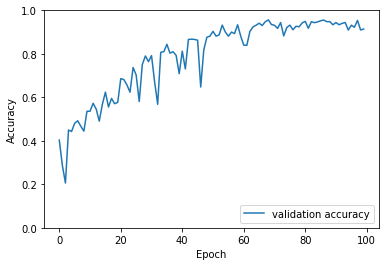

In [58]:
import matplotlib.pyplot as plt
plt.plot(val_acc_history, label = 'validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')